In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import logging

logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [3]:
import jax
import jax.numpy as jnp

import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint, cic_paint_2d
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.lensing import density_plane, convergence_Born

In [59]:
# Below are a few parameters that generate a low resolution version of the k-TNG simulation

box_size = [200.,200.,4000.]    # Transverse comoving size of the simulation volume
nc = [64, 64, 320]              # Number of transverse voxels in the simulation volume
lensplane_width = 102.5         # Width of each lensplane
field_size = 5                  # Size of the lensing field in degrees
field_npix = 128                # Number of pixels in the lensing field
z_source = jnp.linspace(0,2)    # Source planes

In [60]:
# Defining the coordinate grid for lensing map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [63]:
def make_map(Omega_c=0.2589, sigma8=0.8159):
    # Instantiates a cosmology with desired parameters
    cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

    # Planning out the scale factor stepping to extract desired lensplanes
    n_lens = int(box_size[-1] // lensplane_width)
    r = jnp.linspace(0., box_size[-1], n_lens+1)
    r_center = 0.5*(r[1:] + r[:-1])

    # Retrieve the scale factor corresponding to these distances
    a = jc.background.a_of_chi(cosmology, r)
    a_center = jc.background.a_of_chi(cosmology, r_center)

    # Then one step per lens plane
    stages = a_center[::-1]

    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(nc, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    res = odeint(make_ode_fn(nc), [particles+dx, p], 
                 jnp.concatenate([jnp.atleast_1d(0.1), stages]), cosmo, rtol=1e-5, atol=1e-5)
    
    # Extract the lensplanes
    lensplanes = []
    for i in range(len(a_center)):
        plane = density_plane(states[::-1][i],
                              nc,
                              (i+0.5)*lensplane_width/box_size[-1]*nc[-1],
                              width=lensplane_width/box_size[-1]*nc[-1],
                              plane_resolution=64
                           )
        lensplanes.append((r_center[i], stages[::-1][i], plane))
    
    # Get convergence map
    m = convergence_Born(cosmology, 
                          lensplanes, 
                          dx=box_size[0]/64, 
                          dz=lensplane_width,
                          coords=jnp.array(c).T.reshape(2,field_npix,field_npix),
                          z_source=z_source)
    return m

In [64]:
m = make_map()

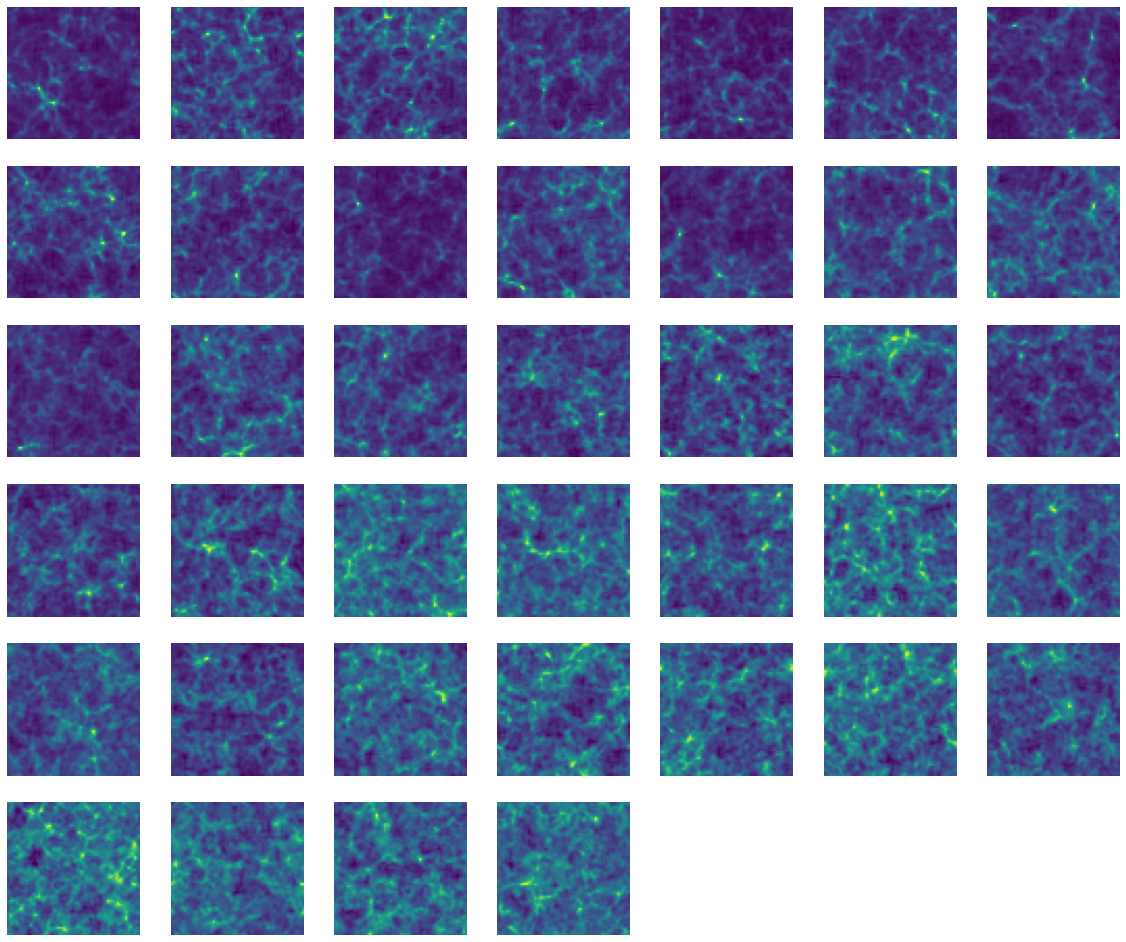

In [43]:
# figure(figsize=[20,20])
# for i in range(39):
#     subplot(7,7,i+1)
#     imshow(lensplanes[i][-1])
#     axis('off')

In [53]:
len(lensplanes)

39

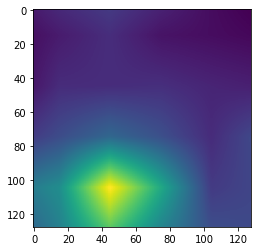

In [68]:
imshow(m[2])

In [66]:
len(m)

50

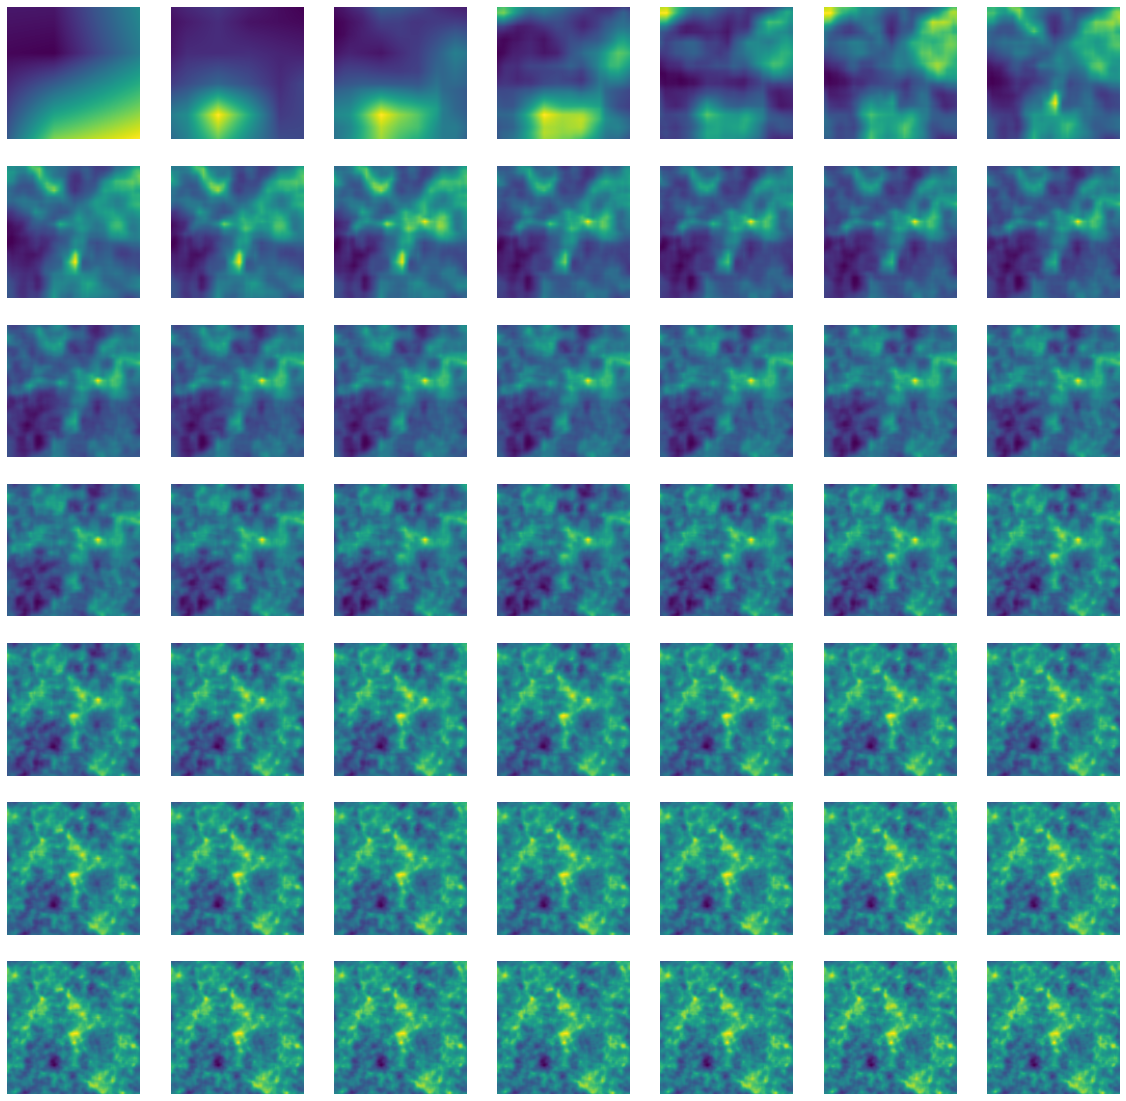

In [70]:
figure(figsize=[20,20])
for i in range(49):
    subplot(7,7,i+1)
    imshow(m[i+1])
    axis('off')